# Session 08 Addendum: Federal Reserve Securities Holdings

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from dotenv import load_dotenv
from datetime import datetime

# Load environment variables
load_dotenv()
fred_api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=fred_api_key)

print(f"FRED API key loaded: {fred_api_key[:10]}...")

FRED API key loaded: 1383c60c37...


## FRED Series IDs for Federal Reserve Balance Sheet

- **TREAST**: U.S. Treasury Securities Held by the Federal Reserve (All Maturities)
- **WSHOMCB**: Mortgage-Backed Securities Held by the Federal Reserve

Alternative series:
- **WSHOTSL**: Treasury Securities Held Outright by the Federal Reserve (alternative)
- **MBST**: Mortgage-Backed Securities (Total)

In [2]:
# Define FRED series IDs for Fed balance sheet components
series_ids = {
    'Treasuries': 'TREAST',  # Treasury securities held by Fed
    'MBS': 'WSHOMCB',  # Mortgage-backed securities
}

# Fetch data from FRED
data = {}
for name, series_id in series_ids.items():
    try:
        series = fred.get_series(series_id, observation_start='2002-01-01')
        # Convert from millions to match chart scale
        data[name] = series
        print(f"Fetched {name}: {len(series)} observations")
    except Exception as e:
        print(f"Error fetching {name} ({series_id}): {e}")

# Create DataFrame
df = pd.DataFrame(data)
print(f"\nDataFrame shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nLatest values (in millions):")
print(df.tail())

Fetched Treasuries: 1204 observations
Fetched MBS: 1204 observations

DataFrame shape: (1204, 2)
Date range: 2002-12-18 00:00:00 to 2026-01-07 00:00:00

Latest values (in millions):
            Treasuries        MBS
2025-12-10   4188975.0  2053665.0
2025-12-17   4204179.0  2053476.0
2025-12-24   4227581.0  2050575.0
2025-12-31   4227801.0  2039024.0
2026-01-07   4235527.0  2039024.0


In [3]:
# Calculate Treasuries + MBS total
df['Treasuries_MBS'] = df['Treasuries'] + df['MBS'].fillna(0)

print("Data summary:")
print(df.describe())
print(f"\nMissing values:")
print(df.isnull().sum())

Data summary:
         Treasuries           MBS  Treasuries_MBS
count  1.204000e+03  1.204000e+03    1.204000e+03
mean   2.326192e+06  1.237858e+06    3.564050e+06
std    1.634791e+06  9.089870e+05    2.496726e+06
min    4.746190e+05  0.000000e+00    4.757180e+05
25%    7.724258e+05  0.000000e+00    7.796872e+05
50%    2.166727e+06  1.475120e+06    3.680848e+06
75%    3.414220e+06  1.780274e+06    4.872436e+06
max    5.771393e+06  2.740185e+06    8.502239e+06

Missing values:
Treasuries        0
MBS               0
Treasuries_MBS    0
dtype: int64


## Figure: Federal Reserve Securities Held Outright

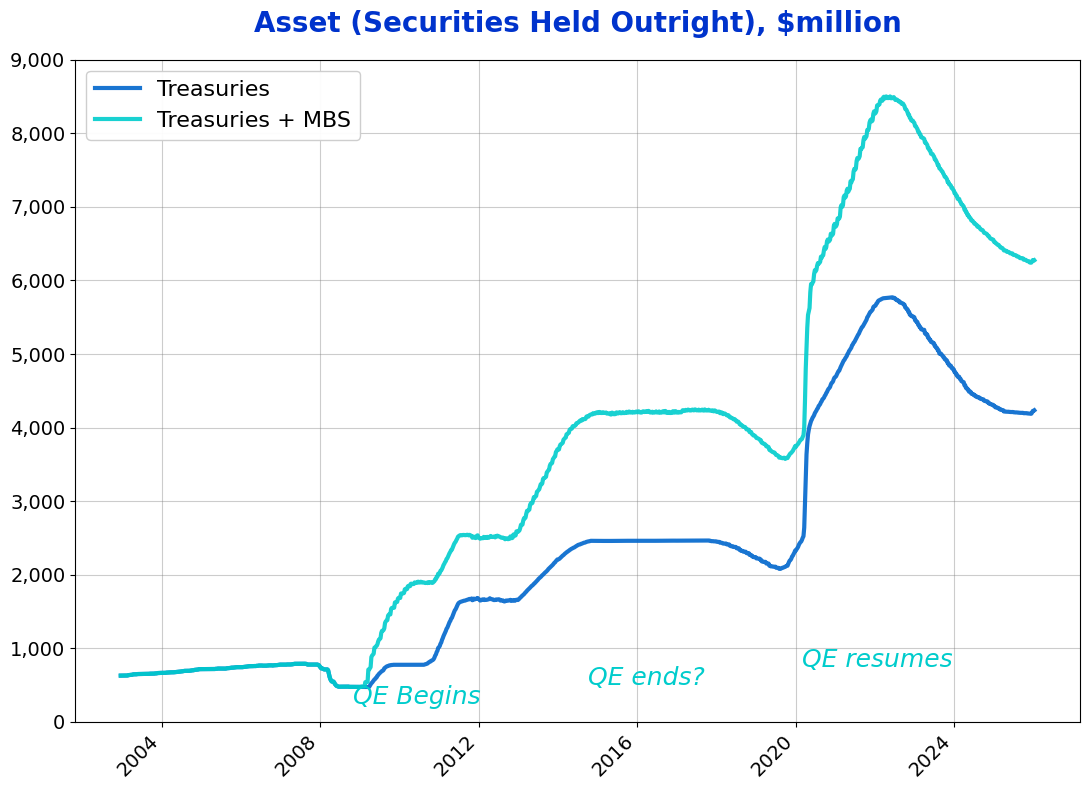

Figure saved to ../figures/fed_securities_holdings.png


In [4]:
# Create the figure matching the style of the provided chart
fig, ax = plt.subplots(figsize=(11, 8))

# Plot both series
ax.plot(df.index, df['Treasuries'] / 1000, 
        color='#0066cc', linewidth=3, label='Treasuries', alpha=0.9)
ax.plot(df.index, df['Treasuries_MBS'] / 1000, 
        color='#00cccc', linewidth=3, label='Treasuries + MBS', alpha=0.9)

# Add annotations for QE periods
# QE Begins (around late 2008)
ax.annotate('QE Begins', 
            xy=(pd.to_datetime('2008-11-01'), 250),
            fontsize=18, color='#00cccc', style='italic')

# QE ends? (around 2014)
ax.annotate('QE ends?', 
            xy=(pd.to_datetime('2014-10-01'), 500),
            fontsize=18, color='#00cccc', style='italic')

# QE resumes (around 2019-2020)
ax.annotate('QE resumes', 
            xy=(pd.to_datetime('2020-03-01'), 750),
            fontsize=18, color='#00cccc', style='italic')

# Customize the plot
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('', fontsize=16)
ax.set_title('Asset (Securities Held Outright), $million', 
             fontsize=20, fontweight='bold', color='#0033cc', pad=20)

# Set y-axis limits and formatting
ax.set_ylim(0, 9000)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Grid styling
ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8, color='gray')
ax.set_axisbelow(True)

# Legend
ax.legend(loc='upper left', fontsize=16, framealpha=0.95)

# Tick label size
ax.tick_params(axis='both', which='major', labelsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../figures/fed_securities_holdings.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/fed_securities_holdings.png")

## Alternative: Using Different FRED Series

In [5]:
# Try alternative series that might better match the chart
alt_series_ids = {
    'Treasuries_Alt': 'WSHOTSL',  # All: Treasury Securities Held Outright
    'MBS_Alt': 'MBST',  # Mortgage-backed securities
}

alt_data = {}
for name, series_id in alt_series_ids.items():
    try:
        series = fred.get_series(series_id, observation_start='2002-01-01')
        alt_data[name] = series
        print(f"Fetched {name}: {len(series)} observations")
        print(f"  Latest value: {series.iloc[-1]:,.0f} million")
    except Exception as e:
        print(f"Error fetching {name} ({series_id}): {e}")

Fetched Treasuries_Alt: 1204 observations
  Latest value: 4,235,527 million
Fetched MBS_Alt: 809 observations
  Latest value: 1,739,733 million


## Analysis: QE Impact on Fed Balance Sheet

In [6]:
# Analyze growth during different QE periods
print("="*80)
print("FEDERAL RESERVE BALANCE SHEET ANALYSIS")
print("="*80)

# Pre-QE (Jan 2008)
pre_qe = df.loc['2008-01-01':'2008-08-01'].mean()
print(f"\nPre-QE (Early 2008):")
print(f"  Treasuries: ${pre_qe['Treasuries']:,.0f} million")
print(f"  Total (Treas + MBS): ${pre_qe['Treasuries_MBS']:,.0f} million")

# Post-QE1 (End 2010)
post_qe1 = df.loc['2010-06-01':'2010-12-01'].mean()
print(f"\nPost-QE1 (Mid-Late 2010):")
print(f"  Treasuries: ${post_qe1['Treasuries']:,.0f} million")
print(f"  Total (Treas + MBS): ${post_qe1['Treasuries_MBS']:,.0f} million")
print(f"  Growth from pre-QE: {((post_qe1['Treasuries_MBS'] / pre_qe['Treasuries_MBS']) - 1) * 100:.1f}%")

# Post-QE3 (End 2014)
post_qe3 = df.loc['2014-10-01':'2015-01-01'].mean()
print(f"\nPost-QE3 (Late 2014):")
print(f"  Treasuries: ${post_qe3['Treasuries']:,.0f} million")
print(f"  Total (Treas + MBS): ${post_qe3['Treasuries_MBS']:,.0f} million")
print(f"  Growth from pre-QE: {((post_qe3['Treasuries_MBS'] / pre_qe['Treasuries_MBS']) - 1) * 100:.1f}%")

# Peak (2022)
peak_date = df['Treasuries_MBS'].idxmax()
peak_value = df.loc[peak_date]
print(f"\nPeak Balance Sheet ({peak_date.strftime('%Y-%m-%d')}):")
print(f"  Treasuries: ${peak_value['Treasuries']:,.0f} million")
print(f"  Total (Treas + MBS): ${peak_value['Treasuries_MBS']:,.0f} million")
print(f"  Growth from pre-QE: {((peak_value['Treasuries_MBS'] / pre_qe['Treasuries_MBS']) - 1) * 100:.1f}%")

# Current
current = df.iloc[-1]
print(f"\nCurrent ({df.index[-1].strftime('%Y-%m-%d')}):")
print(f"  Treasuries: ${current['Treasuries']:,.0f} million")
print(f"  Total (Treas + MBS): ${current['Treasuries_MBS']:,.0f} million")
print(f"  Change from peak: {((current['Treasuries_MBS'] / peak_value['Treasuries_MBS']) - 1) * 100:.1f}%")

print("\n" + "="*80)

FEDERAL RESERVE BALANCE SHEET ANALYSIS

Pre-QE (Early 2008):
  Treasuries: $591,524 million
  Total (Treas + MBS): $591,524 million

Post-QE1 (Mid-Late 2010):
  Treasuries: $807,260 million
  Total (Treas + MBS): $1,899,394 million
  Growth from pre-QE: 221.1%

Post-QE3 (Late 2014):
  Treasuries: $2,459,731 million
  Total (Treas + MBS): $4,183,010 million
  Growth from pre-QE: 607.2%

Peak Balance Sheet (2022-04-13):
  Treasuries: $5,762,054 million
  Total (Treas + MBS): $8,502,239 million
  Growth from pre-QE: 1337.3%

Current (2026-01-07):
  Treasuries: $4,235,527 million
  Total (Treas + MBS): $6,274,551 million
  Change from peak: -26.2%



## Additional Chart: Year-over-Year Growth Rate

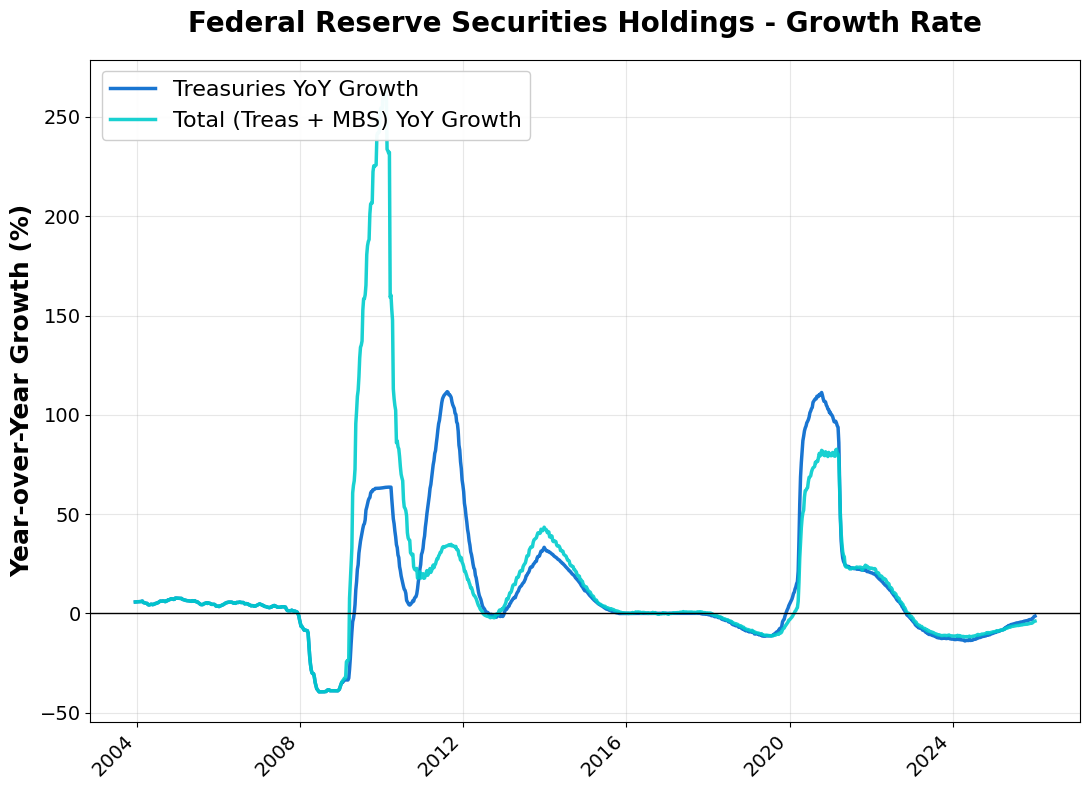

Figure saved to ../figures/fed_securities_growth.png


In [7]:
# Calculate year-over-year growth rates
df['Treasuries_YoY'] = df['Treasuries'].pct_change(periods=52) * 100  # Weekly data
df['Total_YoY'] = df['Treasuries_MBS'].pct_change(periods=52) * 100

# Create figure
fig, ax = plt.subplots(figsize=(11, 8))

# Plot growth rates
ax.plot(df.index, df['Treasuries_YoY'], 
        color='#0066cc', linewidth=2.5, label='Treasuries YoY Growth', alpha=0.9)
ax.plot(df.index, df['Total_YoY'], 
        color='#00cccc', linewidth=2.5, label='Total (Treas + MBS) YoY Growth', alpha=0.9)

# Add zero line
ax.axhline(y=0, color='black', linewidth=1, linestyle='-')

# Customize
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Year-over-Year Growth (%)', fontsize=18, fontweight='bold')
ax.set_title('Federal Reserve Securities Holdings - Growth Rate', 
             fontsize=20, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)
ax.legend(loc='upper left', fontsize=16, framealpha=0.95)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../figures/fed_securities_growth.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/fed_securities_growth.png")

## Chart: Composition - Treasuries vs MBS

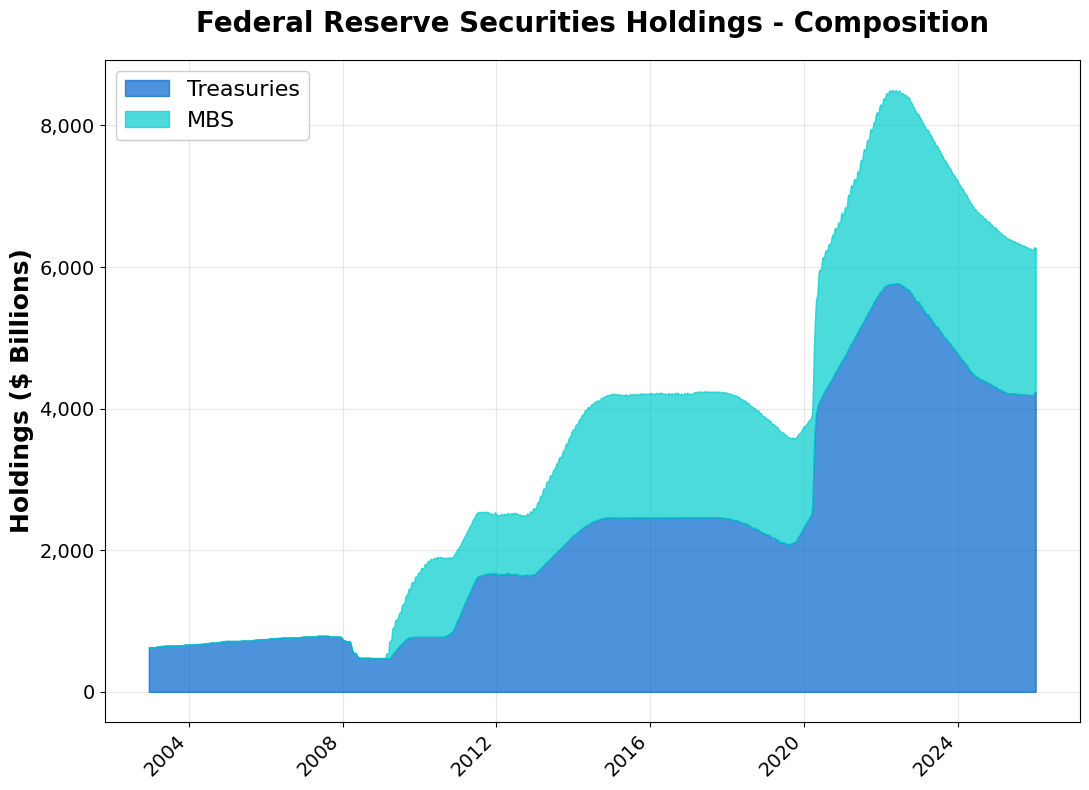

Figure saved to ../figures/fed_securities_composition.png


In [10]:
# Create stacked area chart showing composition
fig, ax = plt.subplots(figsize=(11, 8))

# Prepare data (convert to billions for readability)
treasuries_billions = df['Treasuries'] / 1000
mbs_billions = df['MBS'].fillna(0) / 1000

# Create stacked area plot
ax.fill_between(df.index, 0, treasuries_billions, 
                 color='#0066cc', alpha=0.7, label='Treasuries')
ax.fill_between(df.index, treasuries_billions, treasuries_billions + mbs_billions, 
                 color='#00cccc', alpha=0.7, label='MBS')

# Customize
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Holdings ($ Billions)', fontsize=18, fontweight='bold')
ax.set_title('Federal Reserve Securities Holdings - Composition', 
             fontsize=20, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)
ax.legend(loc='upper left', fontsize=16, framealpha=0.95)
ax.tick_params(axis='both', which='major', labelsize=14)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../figures/fed_securities_composition.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/fed_securities_composition.png")